In [1]:
import torch
import torchvision
from torch.utils import data
import matplotlib.pyplot as plt
import torch.nn as nn 
import torchvision.transforms as transforms
from torchvision import models
from tqdm import tqdm

In [10]:
classes = ('anger', 'digust', 'fear', 'happy','sadness','surprise', 'normal')

path_train = './data/train/'
path_valid = './data/valid/'

transforms_train = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
    transforms.RandomHorizontalFlip(),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5))
])

transforms_vaild = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5))
])
data_train = torchvision.datasets.ImageFolder(root=path_train, transform=transforms_train)
data_valid = torchvision.datasets.ImageFolder(root=path_valid, transform=transforms_vaild)

train_iter = data.DataLoader(dataset=data_train,batch_size=128, shuffle=True)
valid_iter = data.DataLoader(dataset=data_valid,batch_size=128, shuffle=False)

In [3]:
len(data_train)

28709

In [7]:
net = nn.Sequential(
    # 这里使用一个11*11的更大窗口来捕捉对象。
    # 同时，步幅为4，以减少输出的高度和宽度。
    # 另外，输出通道的数目远大于LeNet
    nn.Conv2d(1, 96, kernel_size=11, stride=4, padding=1), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),
    # 减小卷积窗口，使用填充为2来使得输入与输出的高和宽一致，且增大输出通道数
    nn.Conv2d(96, 256, kernel_size=5, padding=2), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),
    # 使用三个连续的卷积层和较小的卷积窗口。
    # 除了最后的卷积层，输出通道的数量进一步增加。
    # 在前两个卷积层之后，汇聚层不用于减少输入的高度和宽度
    nn.Conv2d(256, 384, kernel_size=3, padding=1), nn.ReLU(),
    nn.Conv2d(384, 384, kernel_size=3, padding=1), nn.ReLU(),
    nn.Conv2d(384, 256, kernel_size=3, padding=1), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),
    nn.Flatten(),
    # 这里，全连接层的输出数量是LeNet中的好几倍。使用dropout层来减轻过拟合
    nn.Linear(6400, 4096), nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(4096, 1024), nn.ReLU(),
    nn.Dropout(p=0.5),
    # 最后是输出层。由于这里使用Fashion-MNIST，所以用类别数为10，而非论文中的1000
    nn.Linear(1024, 7))

In [13]:
def evaluate_accuracy(net, data_iter,device):
    """计算在指定数据集上模型的精度"""
    correct = 0
    num = 0
    with torch.no_grad():
        for X, y in data_iter:
            X = X.to(device)
            y = y.to(device)
            outputs = net(X)
            _,predicted = torch.max(outputs.data,1)
            correct += (predicted == y).sum().item()
            num += y.size(0) # numel():获取tensor中的元素数量
    return correct/ num

def train_model(model, num_epochs, device):
    result = {"loss":[], "train_acc":[], "valid_acc":[]}
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr = 0.001,momentum=0.9)
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)
        running_loss = 0
        for i, (X,y) in enumerate(tqdm(train_iter)):
            X = X.to(device)
            y = y.to(device)
            optimizer.zero_grad()
            output = model(X)
            loss = criterion(output, y)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        result['loss'].append(running_loss/225)
        train_acc = evaluate_accuracy(model, train_iter, device)
        valid_acc = evaluate_accuracy(net, valid_iter, device)
        result['train_acc'].append(train_acc)
        result['valid_acc'].append(valid_acc)
        print(running_loss/225,train_acc, valid_acc)
    return result
         

In [9]:
result = train_model(net,60, torch.device('cuda'))

Epoch 1/60
----------


100%|██████████| 225/225 [00:56<00:00,  4.01it/s]


1.9148884911007351 0.2513149186666202 0.24714405126776262
Epoch 2/60
----------


100%|██████████| 225/225 [00:56<00:00,  3.99it/s]


1.8661961444218953 0.2513149186666202 0.24714405126776262
Epoch 3/60
----------


100%|██████████| 225/225 [00:56<00:00,  4.00it/s]


1.8301299720340305 0.2513149186666202 0.24714405126776262
Epoch 4/60
----------


100%|██████████| 225/225 [00:56<00:00,  4.00it/s]


1.8116448969311185 0.25141941551429864 0.24728336584006688
Epoch 5/60
----------


100%|██████████| 225/225 [00:56<00:00,  4.01it/s]


1.8088689475589328 0.2511059249712634 0.2475619949846754
Epoch 6/60
----------


100%|██████████| 225/225 [00:56<00:00,  4.00it/s]


1.805376813146803 0.25354418475042667 0.2520200612984118
Epoch 7/60
----------


100%|██████████| 225/225 [00:56<00:00,  4.01it/s]


1.7992224846945868 0.25274304225155875 0.24853719699080523
Epoch 8/60
----------


100%|██████████| 225/225 [00:56<00:00,  4.01it/s]


1.790910996860928 0.2592218468076213 0.2534132070214544
Epoch 9/60
----------


100%|██████████| 225/225 [00:55<00:00,  4.02it/s]


1.7808971081839668 0.2555992894214358 0.2517414321538033
Epoch 10/60
----------


100%|██████████| 225/225 [00:56<00:00,  4.01it/s]


1.7726140276590983 0.2624264168030931 0.2578712733351909
Epoch 11/60
----------


100%|██████████| 225/225 [00:56<00:00,  4.01it/s]


1.7612338415781656 0.27259744331046015 0.27375313457787687
Epoch 12/60
----------


100%|██████████| 225/225 [00:56<00:00,  4.00it/s]


1.752891584502326 0.28510223274931207 0.28350515463917525
Epoch 13/60
----------


100%|██████████| 225/225 [00:56<00:00,  4.01it/s]


1.7425066788991292 0.2883764673099028 0.29214265812203954
Epoch 14/60
----------


100%|██████████| 225/225 [00:56<00:00,  3.99it/s]


1.7305484104156494 0.2932529868682295 0.3021733073279465
Epoch 15/60
----------


100%|██████████| 225/225 [00:56<00:00,  3.99it/s]


1.7194032414754232 0.30248354174649067 0.31164669824463637
Epoch 16/60
----------


100%|██████████| 225/225 [00:56<00:00,  4.00it/s]


1.7094632403055827 0.30972865651886167 0.3180551685706325
Epoch 17/60
----------


100%|██████████| 225/225 [00:56<00:00,  4.01it/s]


1.7008602804607815 0.31429168553415304 0.3241850097520201
Epoch 18/60
----------


100%|██████████| 225/225 [00:57<00:00,  3.91it/s]


1.692924231953091 0.31955136020063396 0.3216773474505433
Epoch 19/60
----------


100%|██████████| 225/225 [00:56<00:00,  4.01it/s]


1.6855446010165744 0.32773694660211083 0.3328225132348844
Epoch 20/60
----------


100%|██████████| 225/225 [00:56<00:00,  4.00it/s]


1.6751363240347967 0.3299662126859173 0.33226525494566733
Epoch 21/60
----------


100%|██████████| 225/225 [00:56<00:00,  4.00it/s]


1.6681655979156493 0.33954509038977326 0.34424630816383395
Epoch 22/60
----------


100%|██████████| 225/225 [00:56<00:00,  4.00it/s]


1.6559042194154527 0.34302831864572086 0.35135135135135137
Epoch 23/60
----------


100%|██████████| 225/225 [00:56<00:00,  3.98it/s]


1.6415840975443523 0.343550802884113 0.3468932850376149
Epoch 24/60
----------


100%|██████████| 225/225 [00:56<00:00,  4.00it/s]


1.624955571492513 0.35326900971820685 0.37001950404012257
Epoch 25/60
----------


100%|██████████| 225/225 [00:56<00:00,  4.00it/s]


1.6089837333891126 0.37615381935978265 0.37851769295068266
Epoch 26/60
----------


100%|██████████| 225/225 [00:56<00:00,  4.00it/s]


1.5908260779910617 0.3817269845692988 0.3886876567288938
Epoch 27/60
----------


100%|██████████| 225/225 [00:56<00:00,  4.01it/s]


1.5706794765260486 0.38879793792887246 0.39509612705488995
Epoch 28/60
----------


100%|██████████| 225/225 [00:56<00:00,  4.00it/s]


1.560838785701328 0.39687902748267095 0.41167456115909723
Epoch 29/60
----------


100%|██████████| 225/225 [00:56<00:00,  4.01it/s]


1.5455568133460151 0.4029398446480198 0.4193368626358317
Epoch 30/60
----------


100%|██████████| 225/225 [00:56<00:00,  3.98it/s]


1.5355390368567572 0.4119614058309241 0.42811368069100025
Epoch 31/60
----------


100%|██████████| 225/225 [00:56<00:00,  3.98it/s]


1.5252998563978406 0.4101152948552719 0.42156589579269993
Epoch 32/60
----------


100%|██████████| 225/225 [00:56<00:00,  3.98it/s]


1.5144009627236261 0.4110905987669372 0.422123154081917
Epoch 33/60
----------


100%|██████████| 225/225 [00:56<00:00,  4.00it/s]


1.499380521774292 0.42777526211292627 0.44246308163833936
Epoch 34/60
----------


100%|██████████| 225/225 [00:56<00:00,  3.99it/s]


1.4883735466003418 0.4211571284266258 0.44246308163833936
Epoch 35/60
----------


100%|██████████| 225/225 [00:56<00:00,  3.99it/s]


1.4792930094401042 0.4358911839492842 0.4453886876567289
Epoch 36/60
----------


100%|██████████| 225/225 [00:56<00:00,  3.99it/s]


1.4624791759914821 0.4398620641610645 0.45374756199498467
Epoch 37/60
----------


100%|██████████| 225/225 [00:56<00:00,  4.00it/s]


1.4507449791166518 0.4482218119753387 0.45959877403176375
Epoch 38/60
----------


100%|██████████| 225/225 [00:56<00:00,  4.01it/s]


1.4360106897354126 0.4476296631718277 0.4611312343271106
Epoch 39/60
----------


100%|██████████| 225/225 [00:56<00:00,  3.99it/s]


1.4228131951226128 0.4541781322930092 0.4626636946224575
Epoch 40/60
----------


100%|██████████| 225/225 [00:56<00:00,  4.00it/s]


1.4112030739254422 0.46553345640739835 0.47408748955140706
Epoch 41/60
----------


100%|██████████| 225/225 [00:56<00:00,  4.01it/s]


1.393001101811727 0.46999198857501134 0.4767344664251881
Epoch 42/60
----------


100%|██████████| 225/225 [00:56<00:00,  4.00it/s]


1.3794823853174845 0.4793270403009509 0.4906659236556144
Epoch 43/60
----------


100%|██████████| 225/225 [00:56<00:00,  3.99it/s]


1.3629725710550944 0.4771674387822634 0.4878796322095291
Epoch 44/60
----------


100%|██████████| 225/225 [00:56<00:00,  4.01it/s]


1.3520310926437378 0.49096102267581593 0.49791028141543603
Epoch 45/60
----------


100%|██████████| 225/225 [00:56<00:00,  3.98it/s]


1.3325299808714124 0.4955588839736668 0.5032042351629981
Epoch 46/60
----------


100%|██████████| 225/225 [00:56<00:00,  4.00it/s]


1.3247020726733738 0.4852833606186213 0.49791028141543603
Epoch 47/60
----------


100%|██████████| 225/225 [00:56<00:00,  3.99it/s]


1.3158711189693875 0.5028039987460379 0.5108665366397325
Epoch 48/60
----------


100%|██████████| 225/225 [00:56<00:00,  3.98it/s]


1.298434429168701 0.5028039987460379 0.5107272220674283
Epoch 49/60
----------


100%|██████████| 225/225 [00:56<00:00,  3.99it/s]


1.2878589640723335 0.5141593228604271 0.5183895235441627
Epoch 50/60
----------


100%|██████████| 225/225 [00:56<00:00,  3.99it/s]


1.2777187633514404 0.5186526873105994 0.5199219838395096
Epoch 51/60
----------


100%|██████████| 225/225 [00:55<00:00,  4.05it/s]


1.2606538995107015 0.5220662510014281 0.5245193647255503
Epoch 52/60
----------


100%|██████████| 225/225 [00:56<00:00,  3.99it/s]


1.2519471814897325 0.5235292068689261 0.5281415436054612
Epoch 53/60
----------


100%|██████████| 225/225 [00:56<00:00,  4.00it/s]


1.243642741839091 0.5312619735971298 0.5374756199498467
Epoch 54/60
----------


100%|██████████| 225/225 [00:56<00:00,  4.00it/s]


1.2343793551127116 0.5420599811905674 0.5359431596544999
Epoch 55/60
----------


100%|██████████| 225/225 [00:56<00:00,  3.99it/s]


1.2303294483820597 0.5413981678219374 0.5377542490944552
Epoch 56/60
----------


100%|██████████| 225/225 [00:56<00:00,  4.00it/s]


1.2135832442177668 0.5456128740116339 0.5378935636667596
Epoch 57/60
----------


100%|██████████| 225/225 [00:56<00:00,  3.97it/s]


1.2058703268898858 0.5421296457556863 0.5387294511005851
Epoch 58/60
----------


100%|██████████| 225/225 [00:56<00:00,  4.01it/s]


1.2012864658567641 0.5525096659584102 0.5472276400111452
Epoch 59/60
----------


100%|██████████| 225/225 [00:56<00:00,  4.00it/s]


1.1891614556312562 0.5583963217109618 0.5522429646140986
Epoch 60/60
----------


100%|██████████| 225/225 [00:56<00:00,  3.99it/s]


1.1853258466720582 0.5628200215960152 0.546113123432711


In [10]:
torch.save(net,"alexnet")

In [8]:
net = torch.load("alexnet",map_location=torch.device('cpu'))

In [13]:
import numpy as np
np.save("result.npy",result)

In [4]:
import numpy as np
result = np.load("result.npy", allow_pickle=True).item()
result2 = np.load("result-2.npy", allow_pickle=True).item()

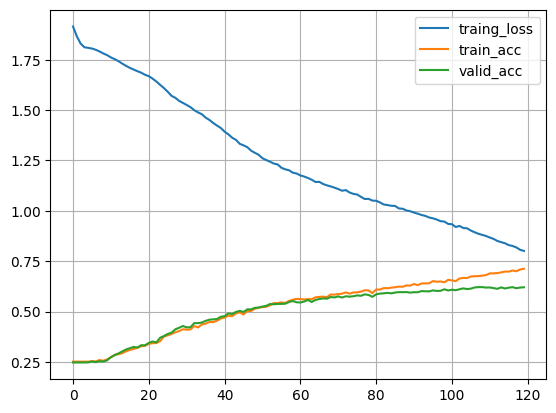

In [7]:
import matplotlib.pyplot as plt
loss = result['loss'] + result2['loss']
train_acc = result['train_acc'] + result2['train_acc']
valid_acc = result['valid_acc'] + result2['valid_acc']

plt.plot(range(len(loss)),loss)
plt.plot(range(len(loss)),train_acc)
plt.plot(range(len(loss)),valid_acc)
plt.grid()
plt.legend(['traing_loss','train_acc','valid_acc'])

In [11]:
class_correct = list(0. for i in range(7))
class_total = list(0. for i in range(7))
with torch.no_grad():
    for data in valid_iter:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(7):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))


Accuracy of anger : 68 %
Accuracy of digust : 50 %
Accuracy of  fear : 21 %
Accuracy of happy : 92 %
Accuracy of sadness : 30 %
Accuracy of surprise : 60 %
Accuracy of normal : 72 %


In [16]:
evaluate_accuracy(net,valid_iter, torch.device('cpu'))

0.622318194483143